In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from pathlib import Path

In [36]:
def main_pipeline(adata, n_components=15, resolution=0.1):
    adata = adata.copy()  
    # -----------------------------------------Normalization-----------------------------------------------
    sc.pp.normalize_total(adata, target_sum=1e4)  # CPM normalization
    sc.pp.log1p(adata)  # Log-transform
    
    # -----------------------------------------FindVariableFeatures-----------------------------------------------
    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        flavor='seurat',   
    ) 
    # -----------------------------------------Scaling-----------------------------------------------
    sc.pp.scale(adata, max_value=10)  # Z-score normalization
    # -----------------------------------------PCA-----------------------------------------------
    sc.tl.pca(adata, svd_solver='arpack', n_comps=n_components)    
    # -----------------------------------------Clustering-----------------------------------------------
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_components)
    sc.tl.leiden(adata, resolution=resolution, key_added='clusters') 
    # -----------------------------------------UMAP-----------------------------------------------
    sc.tl.umap(adata, n_components=n_components)
    return adata
  

## TEST

### URL: https://www.10xgenomics.com/datasets/human-glioblastoma-multiforme-3-v-3-whole-transcriptome-analysis-3-standard-4-0-0

In [72]:
data_dir = "/mnt/jack-5/amismailov/CAF_study/GCF_2/filtered_feature_bc_matrix_2"
adata = sc.read_10x_mtx(
    data_dir,
    var_names='gene_symbols',
    make_unique=True,
    gex_only=True   
)

In [73]:
# -----------------------------------------QC and filtering-----------------------------------------------
sc.pp.calculate_qc_metrics(adata, inplace=True)


adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

adata.obs['nFeature_RNA'] = adata.obs['n_genes_by_counts']
adata.obs['nCount_RNA'] = adata.obs['total_counts']
adata.obs['mitoPercent'] = adata.obs['pct_counts_mt']
 
print(f"Размер  датасета: {adata.shape}")

Размер  датасета: (5604, 36601)


In [74]:
adata = adata[
    (adata.obs['nFeature_RNA'] > 400) & 
    (adata.obs['nFeature_RNA'] < 7000) & 
    (adata.obs['nCount_RNA'] < 30e3) &
    (adata.obs['nCount_RNA'] > 1e3) & 
    (adata.obs['mitoPercent'] < 15)]

print(f"После фильтрации: {adata.shape[0]} клеток, {adata.shape[1]} генов")


После фильтрации: 4608 клеток, 36601 генов


# Model upload

In [78]:
from GlioblastomaCellFinder import GCF
model = GCF()
annotation = model.predict(adata)

In [79]:
annotation

,label
AAACCCAAGGCGATAC-1,Glioblastoma cells
AAACCCACAAGTCCCG-1,Glioblastoma cells
AAACCCACAGATGCGA-1,Stromal cells
AAACCCACAGGTGAGT-1,Stromal cells
AAACCCAGTCTTGCGG-1,Glioblastoma cells
...,...
TTTGGTTTCGCTACAA-1,Stromal cells
TTTGTTGAGGGTACGT-1,Stromal cells
TTTGTTGCATCCGGTG-1,Stromal cells
TTTGTTGGTCTACACA-1,Stromal cells


In [80]:
adata = main_pipeline(adata)

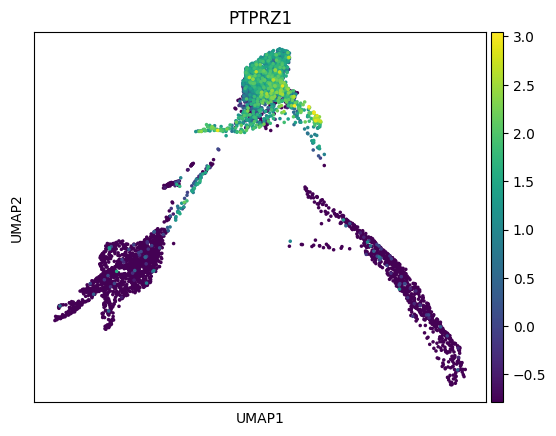

In [81]:
sc.pl.umap(adata, color='PTPRZ1')

In [82]:
assert (adata.obs.index == adata.obs.index.astype(str)).all
assert (annotation.index == annotation.index.astype(str)).all

# Add annotation:
adata.obs.loc[annotation.index, 'label'] = annotation['label']
adata.obs['label'] = adata.obs['label'].astype('category')

/mnt/jack-5/amismailov/micromamba/envs/envs/amismailov/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


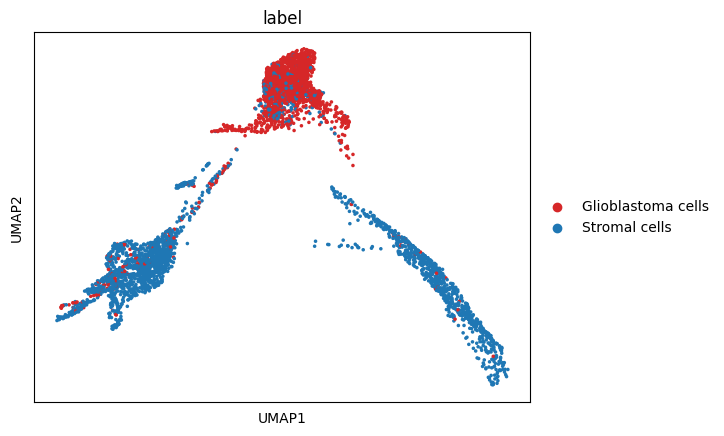

In [83]:
my_colors = ['#D62728', '#1F77B4']   
sc.pl.umap(adata, color='label', palette=my_colors)